In [277]:
import os
import numpy as np
import datetime
from tensorflow_core.python.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import pandas as pd
# import tensorflow.compat.v1
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects   # 自定義gelu
import tensorflow as tf

np.random.seed(10)

In [278]:
sentence_type = 'SA1'
# sentence_type = 'SA2'
# sentence_type = 'SA'

Tr_ver = 'orig_12_1_DR25_M_'
Te_ver = 'orig_12_1_DR25_M_'

Tr_ver = 'pe_12_1_DR25_M_'
Te_ver = 'pe_12_1_DR25_M_'

# Tr_ver = 'orig_2612_1_DR25_M_'
# Te_ver = 'orig_2612_1_DR25_M_'

# Tr_ver = 'pe_2612_1_DR25_M_'
# Te_ver = 'pe_2612_1_DR25_M_'

Tr_ver += sentence_type + '_'
Te_ver += sentence_type + '_'

# Tr_ver += '2_'
# Te_ver += '2_'

shape = 12

now_path = r'D:\TIMITDIC_231101'
data_path = now_path + '_data'

Tr_CDF_path = os.path.join(data_path, 'TRAIN', 'cnn_dataset_EMAX')
Te_CDF_path = os.path.join(data_path, 'TEST', 'cnn_dataset_EMAX')

Tr_DS_path = os.path.join(Tr_CDF_path, 'logEnergyFB', Tr_ver + 'SoundDataset.npz')
# Tr_DS_path = os.path.join(Tr_CDF_path, 'mfcc', Tr_ver + 'SoundDataset.npz')
# Tr_DS_path = os.path.join(Tr_CDF_path, 'mix', Tr_ver + 'SoundDataset.npz')

Te_DS_path = os.path.join(Te_CDF_path, 'logEnergyFB', Te_ver + 'SoundDataset.npz')
# Te_DS_path = os.path.join(Te_CDF_path, 'mfcc', Te_ver + 'SoundDataset.npz')
# Te_DS_path = os.path.join(Te_CDF_path, 'mix', Te_ver + 'SoundDataset.npz')

In [279]:
Tr_DS = np.load(Tr_DS_path)
Te_DS = np.load(Te_DS_path)

train_value, train_label = Tr_DS['TrainValue'], Tr_DS['TrainLabel_class']
test_value, test_label = Te_DS['TestValue'], Te_DS['TestLabel_class']
# test_value, test_label, test_label2 = Te_DS['TestValue'], Te_DS['TestLabel_class'], Te_DS['TestLabel_type']

train_value_4D = train_value.reshape(train_value.shape[0], shape, shape, 1).astype('float32')
test_value_4D = test_value.reshape(test_value.shape[0], shape, shape, 1).astype('float32')

# 向量轉換為二進制(只有0和1)的矩陣類型
# 但train_label、test_label原先資料就都是0跟1?
train_label_OneHot = np_utils.to_categorical(train_label)
test_label_OneHot = np_utils.to_categorical(test_label)

In [280]:
class Davis( Activation ):    
    def __init__(self, activation, **kwargs):
        super(Davis, self).__init__(activation, **kwargs)
        self.__name__ = 'custom_gelu'

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Davis(custom_gelu)})
get_custom_objects().update({'Davis': (Activation)})

In [281]:
activation_cate = 'relu'
activation_cate = 'custom_gelu'
# activation_cate = 'sigmoid'
# activation_cate = 'elu'
# activation_cate = 'tanh'
kernel_size = 3

model = Sequential()
model.add(Conv2D(32, (kernel_size, kernel_size), input_shape=(shape, shape, 1), padding='same', activation=activation_cate))
model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(Conv2D(64, (kernel_size, kernel_size), padding='same', activation=activation_cate))
# model.add(Conv2D(128, (3, 3), padding='same', activation='custom_gelu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='custom_gelu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation=activation_cate))
# model.add(Dropout(0.2))
model.add(Dense(32, activation=activation_cate))
model.add(Dropout(0.2))
model.add(Dense(16, activation=activation_cate))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [282]:
model.summary()
model.compile(loss='mean_squared_error',  # mean_squared_error, binary_crossentropy, categorical_crossentropy
              optimizer="adam",  # sgd, rmsprop, adam
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 12, 12, 32)        320       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 3, 3, 64)          0         
__________

In [283]:
# 創建一個早停法的回調函數
# early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_acc', patience=100, restore_best_weights=True)

train_history=model.fit(x=train_value_4D,
                        y=train_label_OneHot,
                        validation_split=0.2,
                        epochs=200,
                        batch_size=150,
                        verbose=2,
                        # callbacks=[early_stopping])
                        )

Train on 64 samples, validate on 17 samples
Epoch 1/200
 - 4s - loss: 0.2501 - acc: 0.4062 - val_loss: 0.2501 - val_acc: 0.4706
Epoch 2/200
 - 0s - loss: 0.2501 - acc: 0.4688 - val_loss: 0.2501 - val_acc: 0.4706
Epoch 3/200
 - 0s - loss: 0.2501 - acc: 0.5000 - val_loss: 0.2502 - val_acc: 0.4706
Epoch 4/200
 - 0s - loss: 0.2498 - acc: 0.5000 - val_loss: 0.2503 - val_acc: 0.4706
Epoch 5/200
 - 0s - loss: 0.2500 - acc: 0.5156 - val_loss: 0.2504 - val_acc: 0.4706
Epoch 6/200
 - 0s - loss: 0.2497 - acc: 0.5156 - val_loss: 0.2504 - val_acc: 0.4706
Epoch 7/200
 - 0s - loss: 0.2496 - acc: 0.5156 - val_loss: 0.2505 - val_acc: 0.4706
Epoch 8/200
 - 0s - loss: 0.2497 - acc: 0.5156 - val_loss: 0.2505 - val_acc: 0.4706
Epoch 9/200
 - 0s - loss: 0.2497 - acc: 0.5312 - val_loss: 0.2505 - val_acc: 0.4706
Epoch 10/200
 - 0s - loss: 0.2502 - acc: 0.5156 - val_loss: 0.2505 - val_acc: 0.4706
Epoch 11/200
 - 0s - loss: 0.2496 - acc: 0.5000 - val_loss: 0.2506 - val_acc: 0.4706
Epoch 12/200
 - 0s - loss: 0.2

{'val_loss': [0.25007128715515137, 0.25011515617370605, 0.250202476978302, 0.2503035366535187, 0.2503737211227417, 0.2504187226295471, 0.25046005845069885, 0.25048649311065674, 0.2505176067352295, 0.25050798058509827, 0.25056135654449463, 0.2506078779697418, 0.2506432831287384, 0.25063061714172363, 0.2506205141544342, 0.2505779266357422, 0.25053879618644714, 0.2504948675632477, 0.2504633069038391, 0.2504393756389618, 0.25023412704467773, 0.2501777112483978, 0.25008729100227356, 0.24987666308879852, 0.24972093105316162, 0.24970702826976776, 0.2501428425312042, 0.2507370710372925, 0.2508513033390045, 0.25059717893600464, 0.25028088688850403, 0.2500423789024353, 0.2495114952325821, 0.24858608841896057, 0.24746499955654144, 0.2460879683494568, 0.24632155895233154, 0.24689708650112152, 0.24879896640777588, 0.25007739663124084, 0.25031694769859314, 0.24998420476913452, 0.249247208237648, 0.24846979975700378, 0.24769999086856842, 0.24657891690731049, 0.24568656086921692, 0.24513886868953705, 

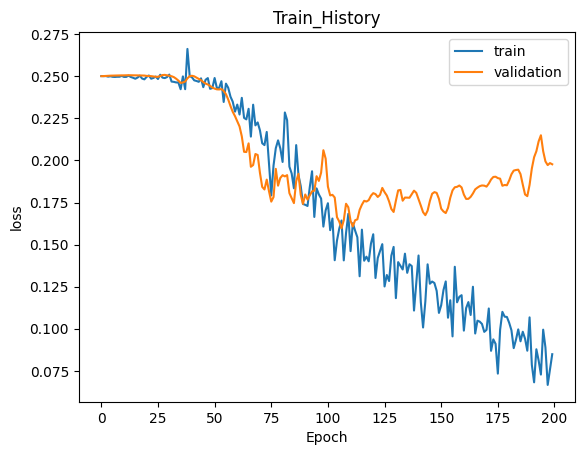

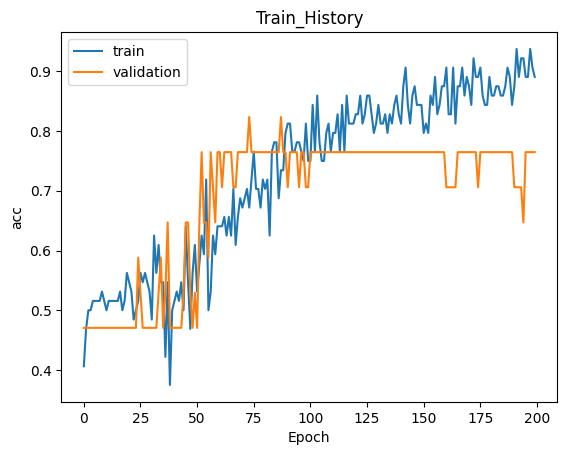

In [284]:
now_str = datetime.datetime.now()
now_str = datetime.datetime.strftime(now_str, '%Y%m%d_%H%M%S')

def show_train_history(train_history, train, validation):
    # 定義show_train_history函數，輸入下列參數:之前訓練過程所產生的train_history、
    # ...訓練資料的執行結果、驗證資料的執行結果
    print(train_history.history)
    plt.style.use('default')
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train_History')  # 顯示圖的標題
    plt.ylabel(train)  # 顯示y軸的標籤
    plt.xlabel('Epoch')  # 設定x軸標籤是'Epoch'
    plt.legend(['train', 'validation'], loc='best')
    # 設定國例是顯示'train', 'validation',位置在左上角

    train_history_path = os.path.join(now_path, 'train_history', Tr_ver)
    os.makedirs(train_history_path, exist_ok=True)

    plt.savefig(os.path.join(train_history_path, now_str + '_' + train + '.png'), bbox_inches='tight', pad_inches=0)

    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'acc', 'val_acc')
# show_train_history(train_history, 'accuracy', 'val_accuracy')

In [285]:
scores = model.evaluate(test_value_4D, test_label_OneHot)
print('loss=', scores[0], '\nacc=', scores[1])

f = open(os.path.join(now_path, 'train_history', 'train_history.txt'), 'a+')  # a+

content = f.read()
f.seek(0, 0)

f.write('\n' + '---------------------------------' + '\n')
f.write('\n' + '*****' + Tr_ver + '*****' + '\n')
f.write(now_str + '\n')
f.write('loss=' + '\n' + str(scores[0]) + '\n')
f.write('acc=' + '\n' + str(scores[1]))

f.write('\n' + content)
f.close()

32/32 [==============================] - 0s 156us/step
loss= 0.17985883355140686 
acc= 0.8125


In [286]:
# 使用pd.crosstab建立混淆矩陣，輸入下列參數:
prediction = model.predict_classes(test_value_4D)
pd.crosstab(test_label,  # 測試資料數字影像的其實值
            prediction,  # 測試資料數字影像的預測結果
            rownames=['label'],  # 設定行的名稱是label
            colnames=['predict'])  # 設定列的名稱是predict

predict,0,1
label,,
0,13,4
1,2,13


In [ ]:
MWpath = os.path.join(now_path, '..\..', 'model_weight')
os.makedirs(MWpath, exist_ok=True)
Wver = now_path.split('\\')[-1]
model.save(os.path.join(MWpath, Tr_ver + 'SoundWeight_' + Wver + '_type2.h5'))